**Road Traffic Accidents Analysis**

Github link: https://github.com/Khaled2466/DSCI-235 


*Introduction*

One of the major public health and safety challenges of our time is road traffic accidents as based on official reports of WHO, there were 1.35 million road traffic deaths worldwide in year 2016. To add more salt on the injury, road traffic crashes are also the primary cause of mortality for those aged 15 to 29 years. At the moment, these injuries rank as the eighth leading cause of death across all age groups globally and projections show that they may rise to the seventh leading cause by 2030 based on a 2025 WHO report.
For this analysis, I focus on Addis Ababa which is the capital of Ethiopia and has unique road safety challenges due to its aging infrastructure and rapid urbanization. The dataset which is used in this report is titled ‘Road Traffic Accidents in Addis Ababa’ and is sourced from Kaggle (https://www.kaggle.com/datasets/saurabhshahane/road-traffic-accidents/data) and it includes police-reported accident records from 2017 to 2020 which will be very helpful to identify the factors influencing road accidents in an urban area.

*Dataset preparation*

As the raw dataset was downloaded from the source, it was observed that it is not suitable for statistical analysis as it had many missing cells and incomplete information which were represented in "NA" format. Such inconsistencies and missing values can influence the reliability of statistical results and machine learning models in a negative way and thus I need to tackle with this problem and perfrom a data preprocessing before I dive into the statitical analysis of our data.
To solve this problem I used 2 techniques:

1. Omission of rows with critical missing values: In some cases data missing and could not be inferred and such records were removed from the dataset.
2. Imputation of missing values: For attributes where missing data was less critical, I replaced missing entries with either the mean or median of the corresponding healthy values within the same attribute which helps us to minimize bias and keep the statistical properties of the dataset.

For our categorical varibles like Age, I standardize their format to ensure categorical values follow a uniform format which is especially useful for analysis and visualization later. After perofrming all these changes, I save the new cleaned dataset as a new csv file.

In [2]:
import pandas as pd

df = pd.read_csv('RTA Dataset.csv', na_values=['na', ''])

print("Initial shape:", df.shape)
print("\nMissing values before cleaning:")
print(df.isnull().sum())

df_clean = df.dropna()
df_clean = df_clean.drop_duplicates()

def clean_categorical(col):
    return col.str.lower().str.strip().str.replace(' ', '_')

categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_clean[col] = clean_categorical(df_clean[col])

df_clean['Time'] = pd.to_datetime(df_clean['Time'], format='%H:%M:%S').dt.hour

df_clean['Age_band_of_driver'] = df_clean['Age_band_of_driver'].str.replace('under_', 'under')
df_clean['Age_band_of_casualty'] = df_clean['Age_band_of_casualty'].str.replace('under_', 'under')

print("\nFinal shape after cleaning:", df_clean.shape)
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())

df_clean.to_csv('cleaned_RTA_dataset.csv', index=False)

print("\nSample of cleaned data:")
print(df_clean.head())

Initial shape: (12316, 32)

Missing values before cleaning:
Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                 4443
Sex_of_casualty                4443
Age_band_of_casualty           4443
Casu

It can be seen that after data cleaning,there are no more missing information in our cleaned dataset and the data is ready to be processed for the analsyis.

*Feature engineering and EDA*

In order for our some of the categorcal variables (like accident severity) to be used in analysis later, I convert them to numeric values or assign binary features to them (as I did for vehicle defects attribute).
I also perform One-Hot Encoding as machine learning models cannot interpret text labels directly and this encoding makes them usable.

In [4]:
severity_mapping = {'slight_injury': 0, 'serious_injury': 1, 'fatal_injury': 2}
df_clean['Accident_severity'] = df_clean['Accident_severity'].map(severity_mapping)

df_clean['Vehicle_defect'] = df_clean['Defect_of_vehicle'].apply(
    lambda x: 1 if x == 'no_defect' else 0
)

In [5]:
categorical_features = [
    'Day_of_week', 
    'Road_surface_type',
    'Weather_conditions',
    'Type_of_collision'
]

df_clean = pd.get_dummies(
    df_clean, 
    columns=categorical_features, 
    prefix=categorical_features
)

In this next step, I load our cleaned dataset and initialize the visualization set up for our plots while showing some basic statitics of our dataset to make sure everything works as I expect.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('cleaned_RTA_dataset.csv')
sns.set(style="whitegrid", palette="pastel")

print("=== Basic Dataset Statistics ===")
print(f"Total accidents: {len(df)}")
print(f"Time range: {df['Time'].min()}:00 - {df['Time'].max()}:00")
print("\nAccident severity distribution:")
print(df['Accident_severity'].value_counts(normalize=True))


=== Basic Dataset Statistics ===
Total accidents: 1847
Time range: 0:00 - 23:00

Accident severity distribution:
slight_injury     0.851651
serious_injury    0.135896
fatal_injury      0.012453
Name: Accident_severity, dtype: float64


Now, I will visualize some attributes of our dataset to understand it better and get useful information out of it and find some patterns if possible.

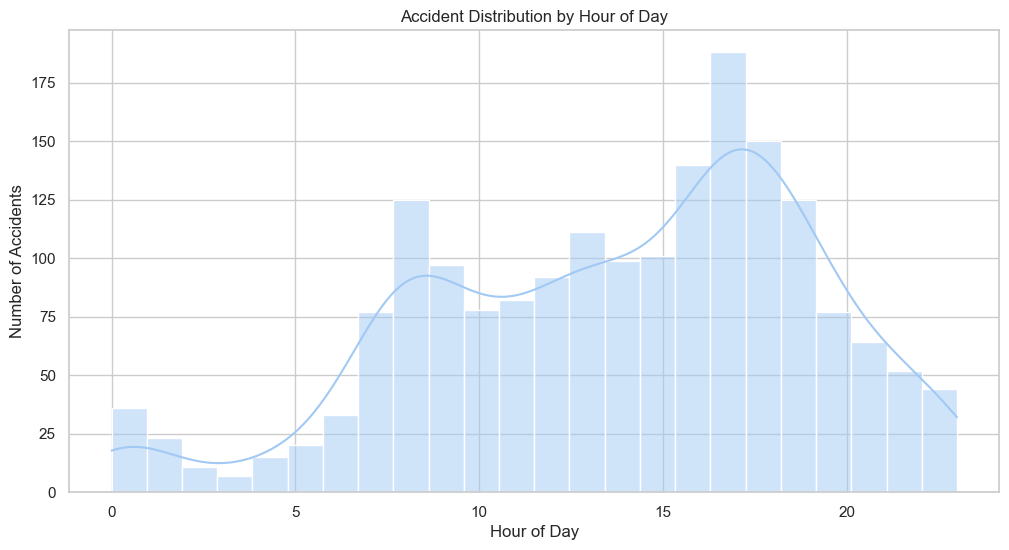

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Time'], bins=24, kde=True)
plt.title('Accident Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.show()

Based on the temporal analysis above, it can be concluded that between 4 PM to 7 PM is the most dangerous time for drivers as we have a clear peak of number of accidents in this interval.

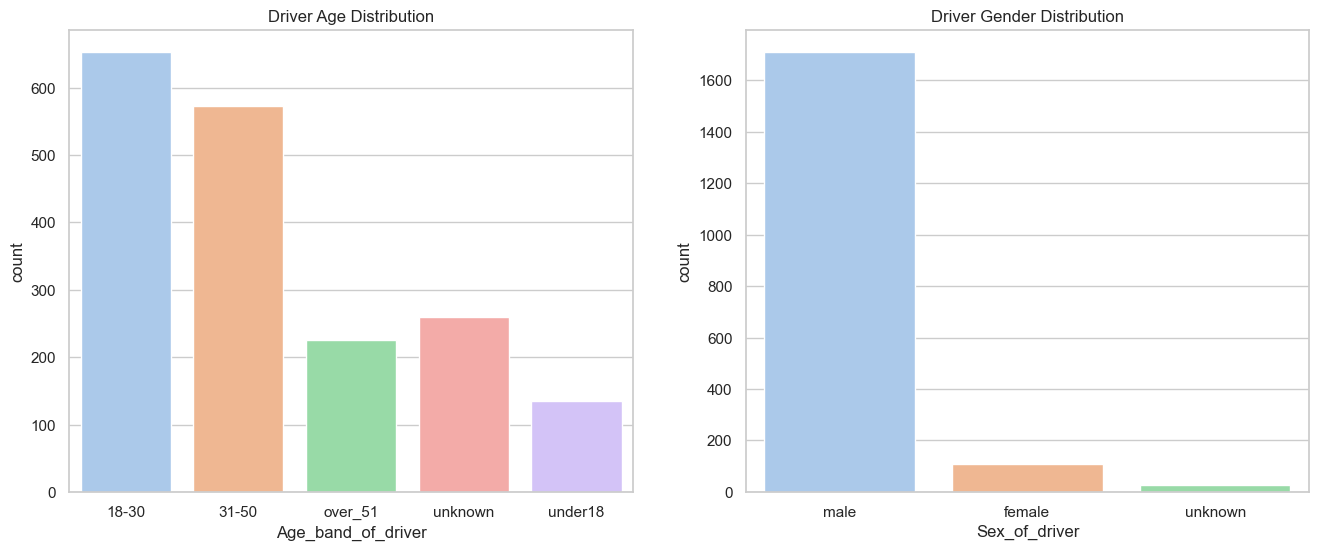

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(x='Age_band_of_driver', data=df, ax=ax[0])
ax[0].set_title('Driver Age Distribution')
sns.countplot(x='Sex_of_driver', data=df, ax=ax[1])
ax[1].set_title('Driver Gender Distribution')
plt.show()

This driver demographic analysis shows that most of the drivers in our dataset are males and are between 18 and 50 years old.

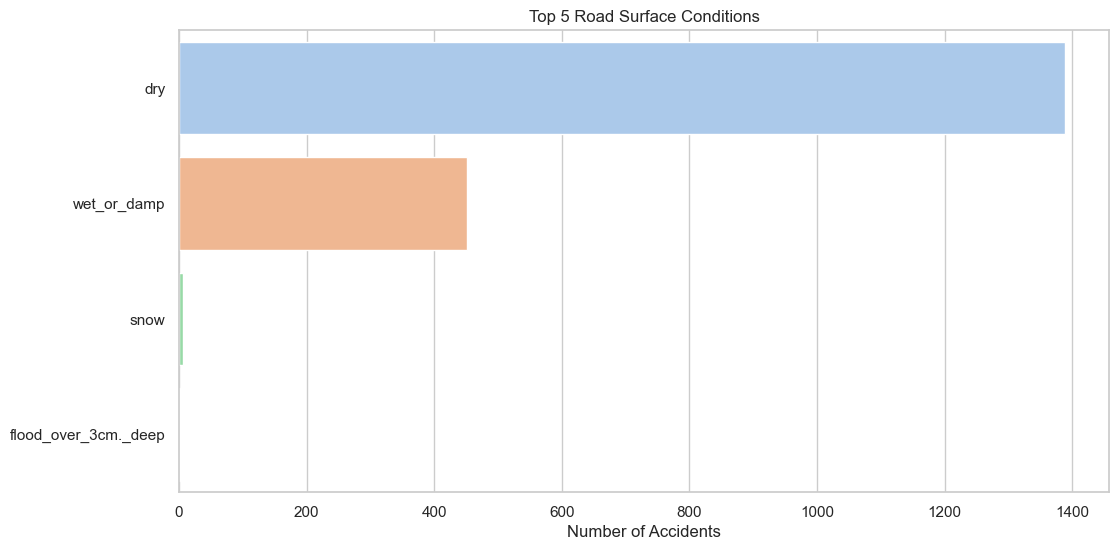

In [9]:
plt.figure(figsize=(12, 6))
road_cond = df['Road_surface_conditions'].value_counts().nlargest(5)
sns.barplot(x=road_cond.values, y=road_cond.index)
plt.title('Top 5 Road Surface Conditions')
plt.xlabel('Number of Accidents')
plt.show()

Road condition analysis above shows that most accidents occur in dry or moderately wet conditions which makes sense since in the area where the dataset was collcted, it barely snows or a significant flood occurs.

Now, I will perform a grouped statitical analysis to understand how different factors (like the number of vehicles, casualties, and time of accident) vary based on accident severity. 

In [11]:
severity_factors = df.groupby('Accident_severity').agg({
    'Number_of_vehicles_involved': 'mean',
    'Number_of_casualties': 'mean',
    'Time': 'median'
}).reset_index()
print("\nSeverity Factors Analysis:")
print(severity_factors)



Severity Factors Analysis:
  Accident_severity  Number_of_vehicles_involved  Number_of_casualties  Time
0      fatal_injury                     1.869565              1.913043  15.0
1    serious_injury                     1.880478              1.561753  16.0
2     slight_injury                     2.029879              1.533376  15.0


Before this analysis, one would expect that fatal accidents (fatal_injury) involve more vehicles compared to slight injuries since general knowledge suggests that multi-vehicle collisions are more dangerous but on the contradictory, I see that  slight_injury accidents have more vehicles on average (2.03) compared to fatal (1.87) or serious (1.88). This is due to the fact that multi-vehicle collisions may often be low-speed and cause minor damage whule fatal accidents might involve fewer but higher-impact vehicles.

Also, it can be seen that fatal_injury accidents have significantly more casualties (1.91) vs. serious (1.56) or slight (1.53) which is what I expected.

In addition, time of the accidents confirm our previous temporal analysis result that 3-4 PM are peak accident hours as all severity types cluster around this time. This can show that fatigue or school/work traffic increases risk.

In the next step, in order to  identify redundant variables and to analyze relationships between numerical features in the dataset, I generate a correlation matrix heatmap between our numerical features.

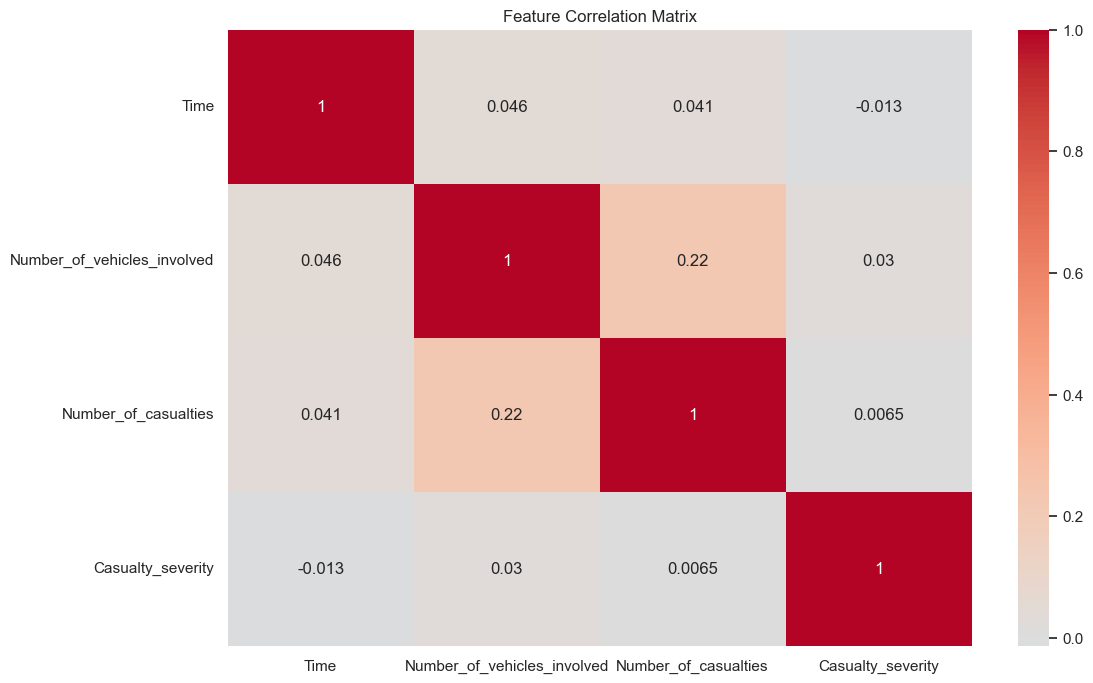

In [13]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

From the correlation heatmap, I can see that there is a rather significant positive correlation between number of casualties and number of vehicles involved which shows that as the number of vehicles involved in an accident increases, we can expect to have more casulaties.

In the next step, I am going to analyze the relationships between categorical features and accident severity. By performing this step I want to know how accident severity varies across time-based categories (day of week), how severity relates to environmental factors (like light conditions) and how severity correlates with driver demographics (age groups).

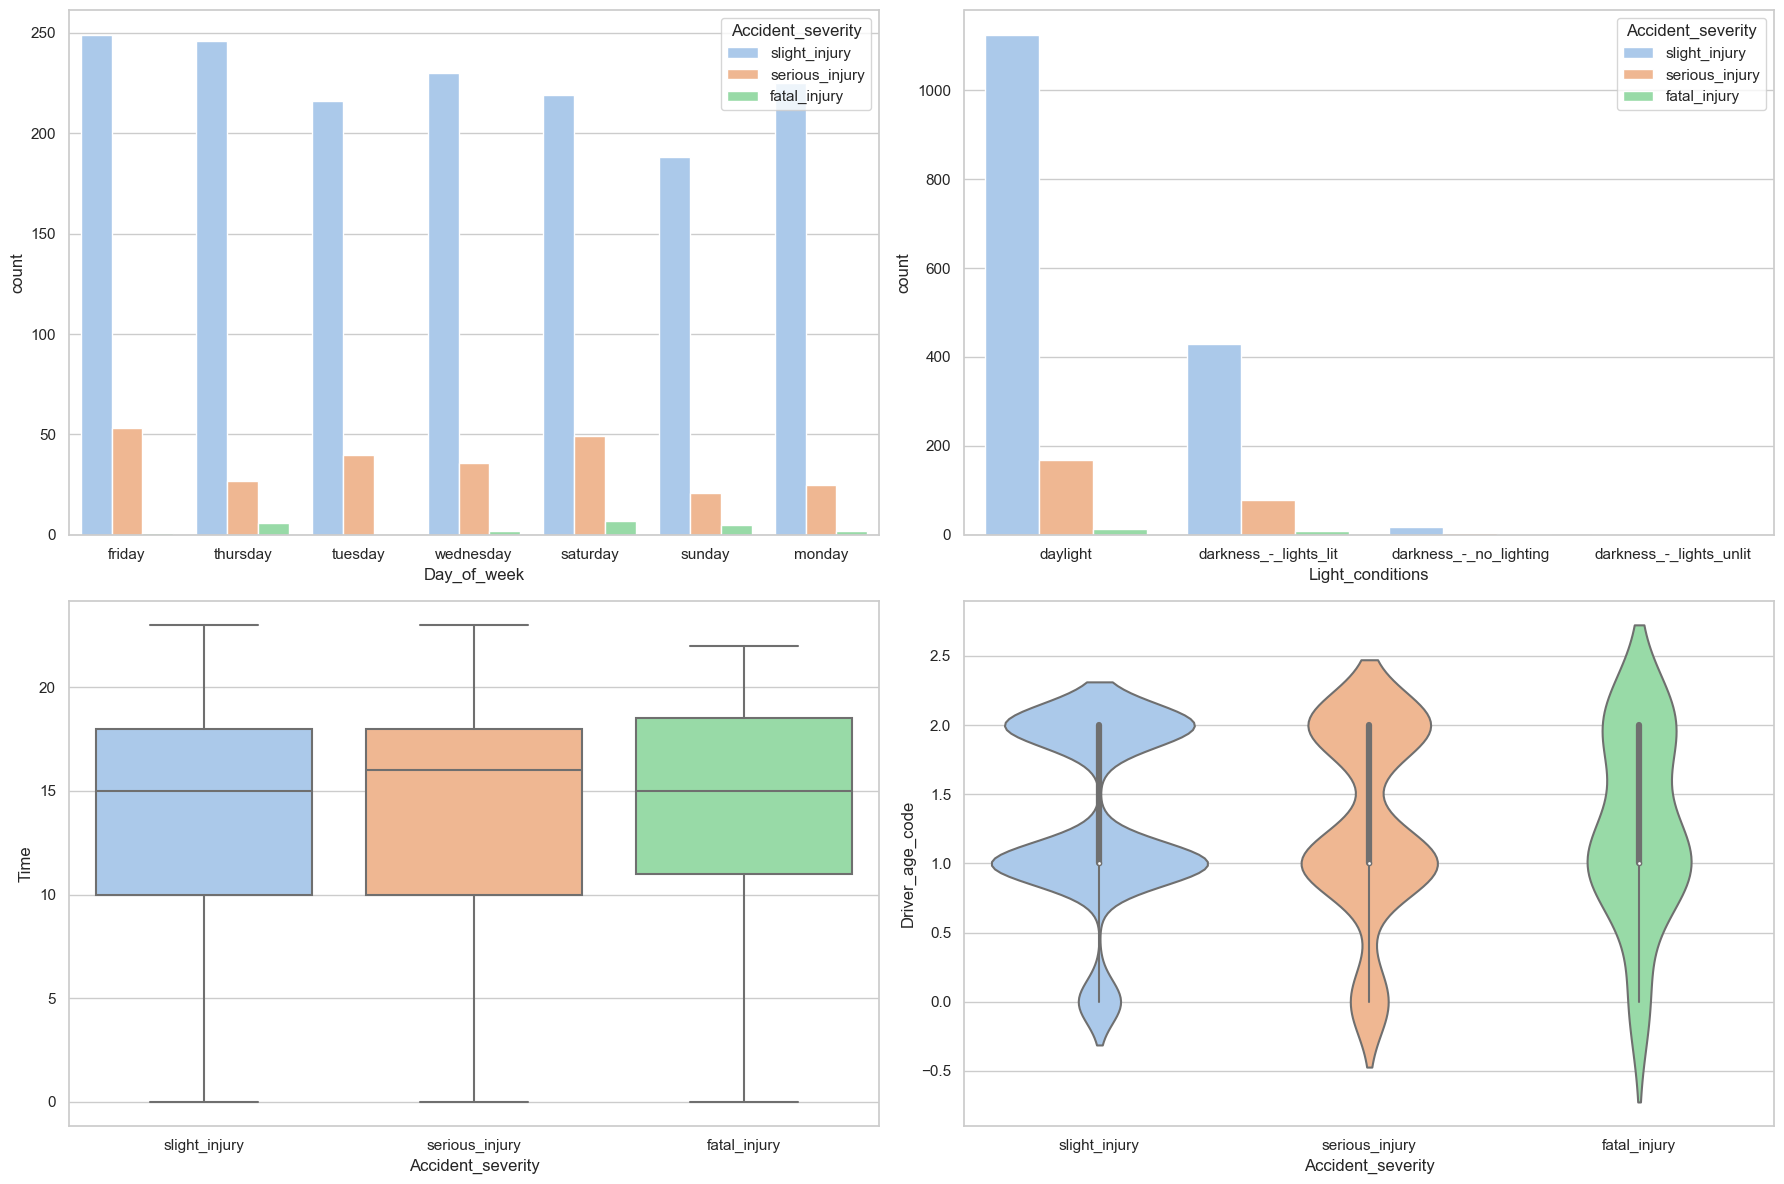

In [14]:
age_mapping = {
    'under18': 0,
    '18-30': 1,
    '31-50': 2,
    'over51': 3
}

df['Driver_age_code'] = df['Age_band_of_driver'].map(age_mapping)

fig, ax = plt.subplots(2, 2, figsize=(18, 12))
sns.countplot(x='Day_of_week', hue='Accident_severity', data=df, ax=ax[0,0])
sns.countplot(x='Light_conditions', hue='Accident_severity', data=df, ax=ax[0,1])
sns.boxplot(x='Accident_severity', y='Time', data=df, ax=ax[1,0])
sns.violinplot(x='Accident_severity', y='Driver_age_code', data=df, ax=ax[1,1])
plt.tight_layout()
plt.show()

From the top right plot, we can conclude that lightening is a key factor to prevent slight injuries in the darkness. Also, top left plot tells us that Sunday has the fewest number of injuries which can be due to the fact that more people stay at home instead of driving on this day.From the violin plot in the down right, we can see that most of the slight injuries are for ages 18 through 50 while fatal injuries is relatively distributed uniformly across all age groups.

In this stage, I want to determine what are the most common causes of accidents.

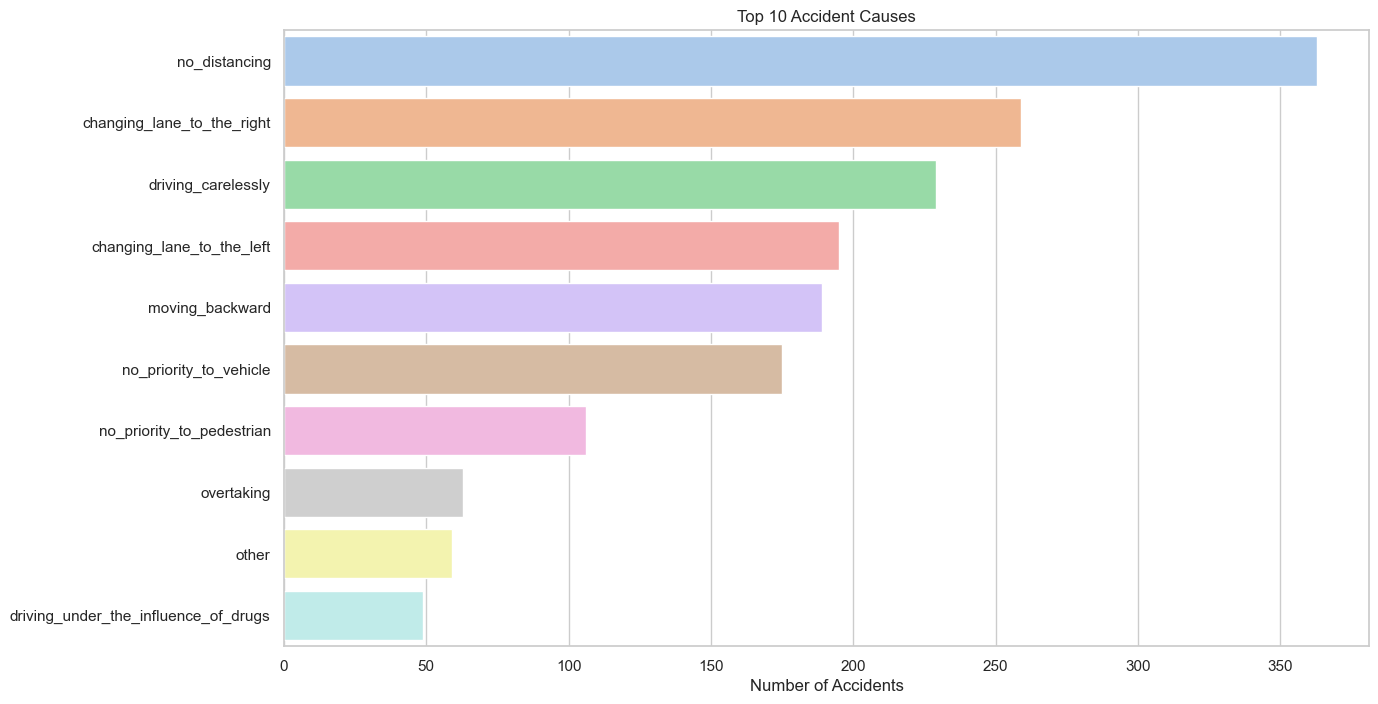

In [15]:
plt.figure(figsize=(14, 8))
cause_counts = df['Cause_of_accident'].value_counts().nlargest(10)
sns.barplot(x=cause_counts.values, y=cause_counts.index)
plt.title('Top 10 Accident Causes')
plt.xlabel('Number of Accidents')
plt.show()

From the plot provided above, we can can see that not having enough distance with other vehicles, changing the lane, careless driving and mving backwards are the most common causes of accidents.

Now, I want to see whether education level affects the number of accidents.

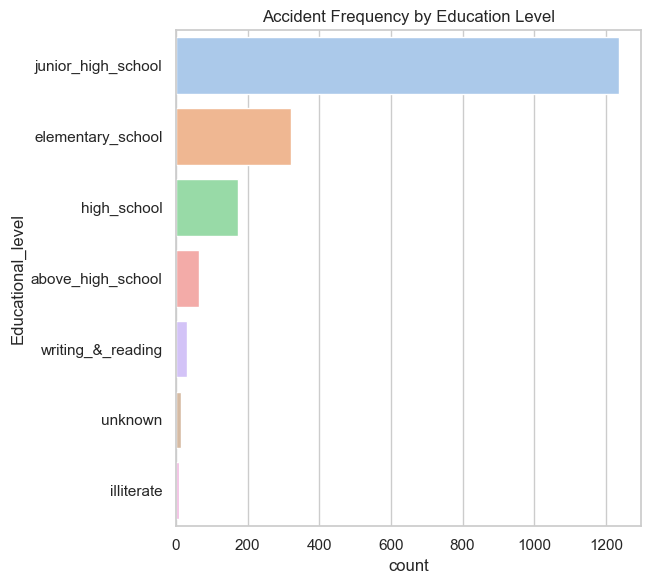

In [19]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 3)
edu_order = df['Educational_level'].value_counts().index
sns.countplot(data=df, y='Educational_level', order=edu_order)
plt.title('Accident Frequency by Education Level')

plt.tight_layout()
plt.show()


We can see that most of the accidents are done by junior high schoolers which shows educational system has to invest more in this area for students in this age interval.

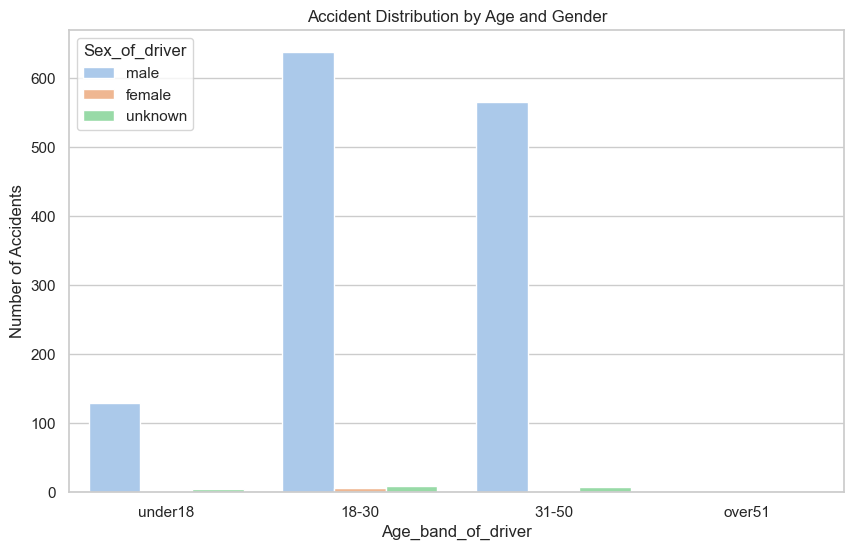

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Age_band_of_driver', hue='Sex_of_driver', order=age_order)
plt.title('Accident Distribution by Age and Gender')
plt.ylabel('Number of Accidents')
plt.show()

In our next analysis, I want to see the effect of vehicle type and driving experience on likelihood of accidents.

<Figure size 1200x800 with 0 Axes>

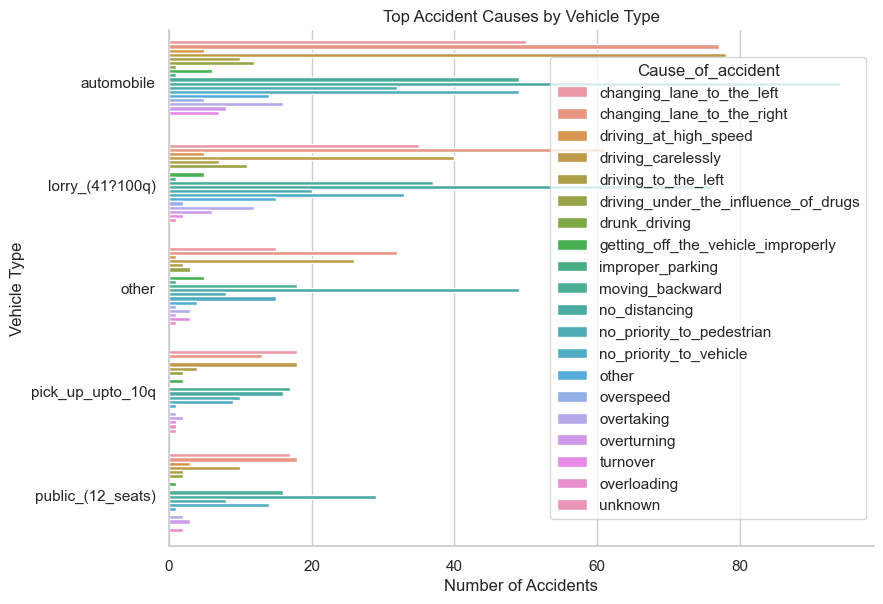

<Figure size 1200x600 with 0 Axes>

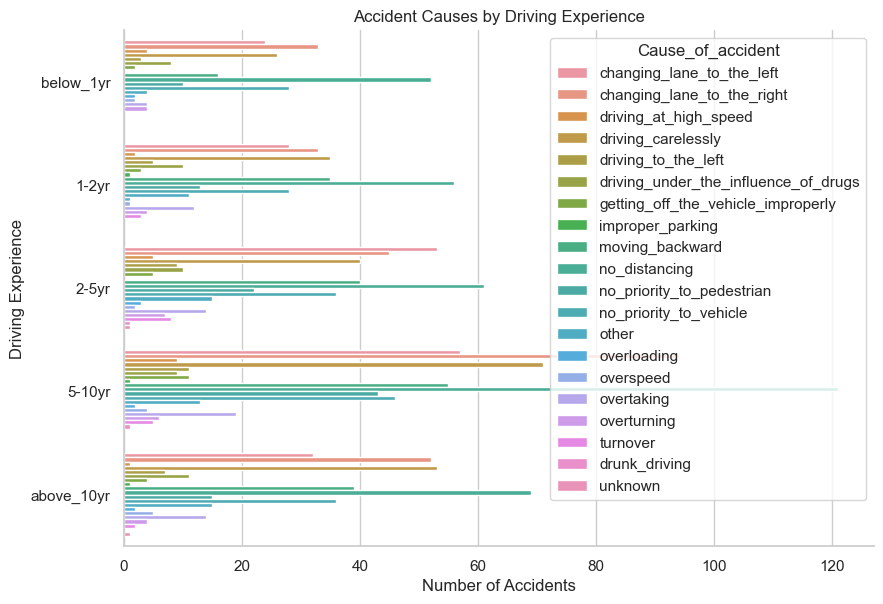

In [21]:
plt.figure(figsize=(12, 8))
vehicle_causes = df.groupby(['Type_of_vehicle', 'Cause_of_accident']).size().reset_index(name='count')
top_vehicles = df['Type_of_vehicle'].value_counts().nlargest(5).index  # Top 5 vehicles

sns.catplot(
    data=vehicle_causes[vehicle_causes['Type_of_vehicle'].isin(top_vehicles)],
    kind='bar',
    x='count',
    y='Type_of_vehicle',
    hue='Cause_of_accident',
    height=6,
    aspect=1.5,
    legend_out=False
)
plt.title('Top Accident Causes by Vehicle Type')
plt.xlabel('Number of Accidents')
plt.ylabel('Vehicle Type')
plt.show()

plt.figure(figsize=(12, 6))
exp_order = ['below_1yr', '1-2yr', '2-5yr', '5-10yr', 'above_10yr']
cause_exp = df.groupby(['Driving_experience', 'Cause_of_accident']).size().reset_index(name='count')

sns.catplot(
    data=cause_exp,
    kind='bar',
    x='count',
    y='Driving_experience',
    hue='Cause_of_accident',
    order=exp_order,
    height=6,
    aspect=1.5,
    legend_out=False
)
plt.title('Accident Causes by Driving Experience')
plt.xlabel('Number of Accidents')
plt.ylabel('Driving Experience')
plt.show()

Upper plot shows us that if you are driving an automobile, changing your lane or having another ditraction like talking to your phone and driving carelessly are the most dangerous factors that can cause you to have an accident. If you are driving a lorry  or a pick up, make sure you don't move backwards since it is the most common reason for this kind of vehicles to have an accident.

When I analyze the accidents from the driver's experience aspect, I can conclude that an amature driver's most common cause to get involved in an accident is moving backwards but as drivers gain experience, changing lane and careless driving become the most fatal mistakes.

Now, I want to get the correlation between demographic factors and accident frequency.

C:\Users\ASUS  N551JW\AppData\Local\Temp\ipykernel_11460\518040365.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df.corr()


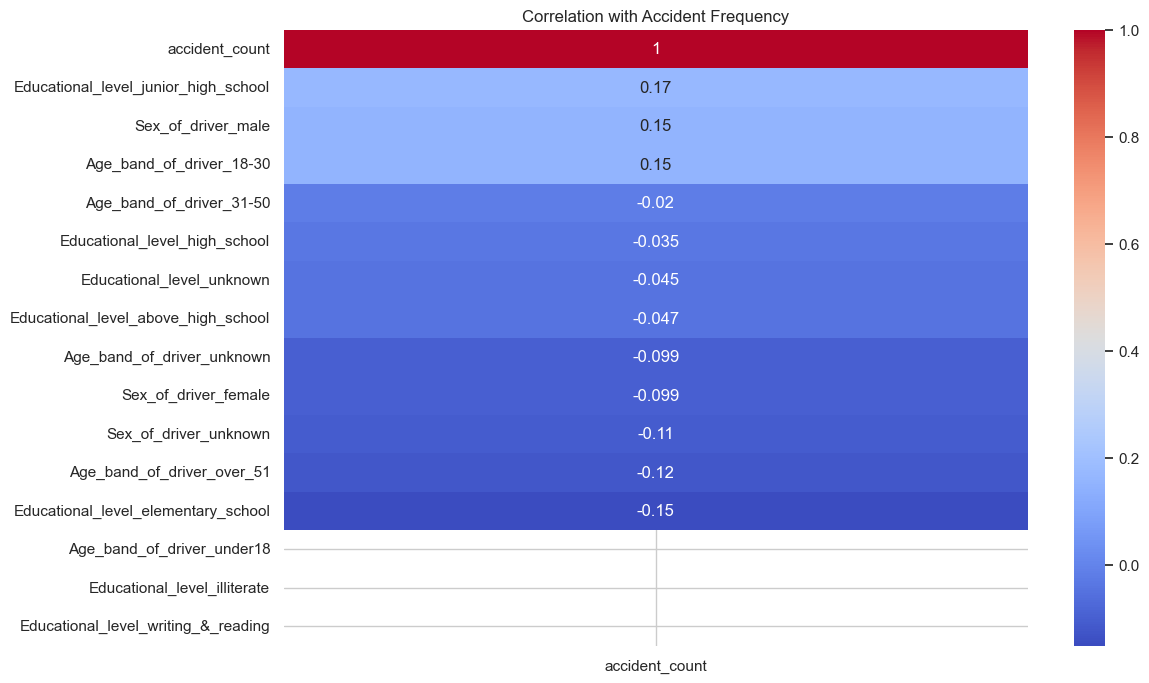

In [22]:
demographic_factors = df[['Age_band_of_driver', 'Sex_of_driver', 'Educational_level']]
demographic_dummies = pd.get_dummies(demographic_factors)

accident_counts = df.groupby(demographic_factors.columns.tolist()).size().reset_index(name='accident_count')

merged_df = pd.merge(demographic_dummies, accident_counts, left_index=True, right_index=True)

correlation_matrix = merged_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['accident_count']].sort_values('accident_count', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlation with Accident Frequency')
plt.show()

Junior high educational level, being male and having an age of between 18 to 30 have the most positive correlation with accident frequency and having any of these features makes a person more likely to have an accident while being older (above 51) has one of the most negative correlation with accident frequency which means elders are less likely to experience accidents. 

In the next step, I want to perform some hypothesis testing to understand whether statitically one factor affects another or not. I start by testing whether driver's gender affects accident frequency or not. So:

Null Hypothesis: H0 : Driver's gender is independent of accident severity

In [36]:
from scipy.stats import chi2_contingency, f_oneway

gender_contingency = pd.crosstab(df['Sex_of_driver'], df['Accident_severity'])
chi2, p, _, _ = chi2_contingency(gender_contingency)
print(f"Gender vs Severity:chi_2={chi2:.2f}, p-value={p:.4f}")


Gender vs Severity:chi_2=0.82, p-value=0.9362


Result: p-value > 0.05

So, we fail to reject H0 and conclude there is no statistically significant association between gender and severity.

In [37]:
exp_cause_contingency = pd.crosstab(df['Driving_experience'], df['Cause_of_accident'])
chi2, p, _, _ = chi2_contingency(exp_cause_contingency)
print(f"\nExperience vs Causes: chi_2={chi2:.2f}, p-value={p:.4f}")



Experience vs Causes: chi_2=116.38, p-value=0.4204


This test is for  Driving Experience vs Accident Causes.

Null Hypothesis: H0: Driving experience is independent of accident causes

p-value > 0.05


So, we fail to reject H0 and conclude there is no statistically significant association between Driving Experience and Accident Causes.

In [25]:
vehicle_groups = [group['Number_of_casualties'] for name, group in df.groupby('Type_of_vehicle')]
f_stat, p = f_oneway(*vehicle_groups)
print(f"\nVehicle Type vs Casualties: F={f_stat:.2f}, p-value={p:.4f}")


Vehicle Type vs Casualties: F=1.95, p-value=0.0130


This test is for  Vehicle Type vs Casualties

Null Hypothesis: H0: All vehicle types have equal mean casualties

p-value < 0.05


So, the result is significant and there is enough evidence to reject the null hypothesis and conclude that different type of vehicles have different risks of casualties.

Now, I want to train a machine learning algorithm named "Random Forest" and see how well it can describe and predict the data.
Then, I want to see which features were the most important and decisive ones for this ML algorithm.

Improved Random Forest Performance:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73       473
           1       0.21      0.47      0.29        75
           2       0.03      0.29      0.06         7

    accuracy                           0.60       555
   macro avg       0.38      0.46      0.36       555
weighted avg       0.79      0.60      0.66       555



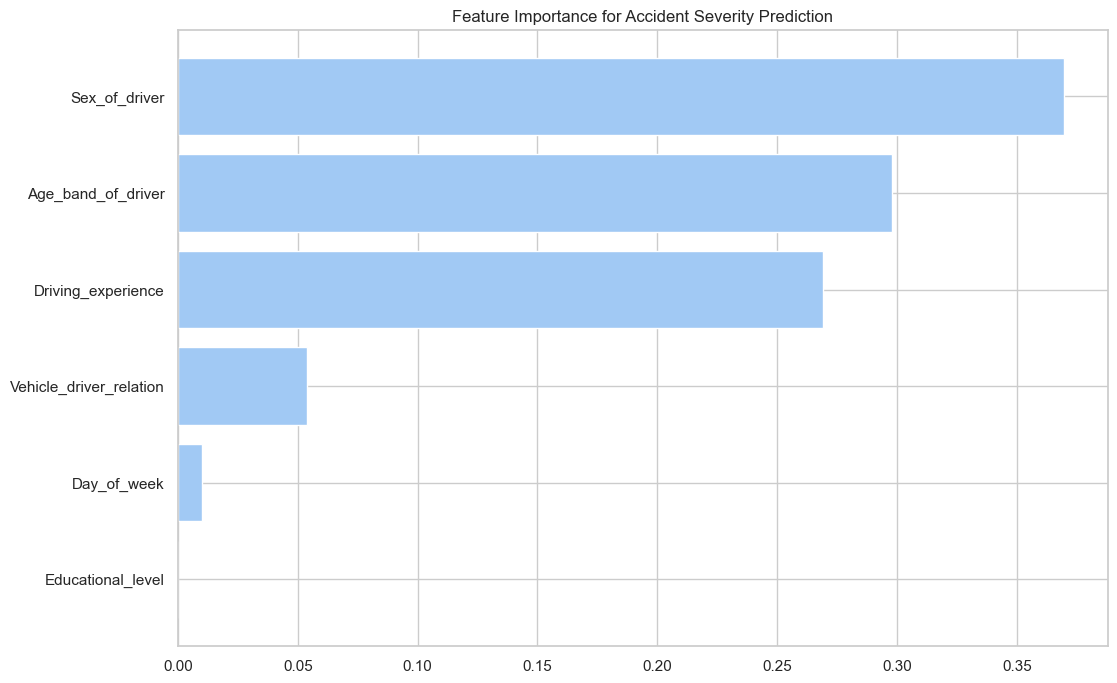

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

preprocessor = make_pipeline(
    SimpleImputer(strategy='most_frequent'), 
    StandardScaler()
)


for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')


X = X.fillna(X.mode().iloc[0])

features = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777, stratify=y
)

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=777)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Improved Random Forest Performance:")
print(classification_report(y_test, y_pred))

rf_model = pipeline.named_steps['randomforestclassifier']
importances = rf_model.feature_importances_

plt.figure(figsize=(12, 8))
sorted_idx = importances.argsort()
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title("Feature Importance for Accident Severity Prediction")
plt.show()

These results show a 60% accuracy dominated by majority class performance while 0.36 vs 0.66 F1 shows model bias toward Class 0.

Class 2 which denotes Fatal have 29% recall at cost of 97% false positives while class 1 which shows serious has 47% recall with 79% false positive rate.

Feature importance chart tells us that the top affecting features for this ML classifier are:sex of driver, age of driver and driving experience which makes total sense.

In previous algorithm, I suspect that domination of some classes over others may have affected the ML model and while the model has basic predictive capability for slight injuries, it requires fundamental improvements to be actionable for severe accident prevention. Thus, I want to tackle this problem by assigning class weights to slight injury and fatal injury to make them participate more on the model to enable the model to predict them better.

Balanced Accuracy: 0.37386243386243384

Classification Report:
                precision    recall  f1-score   support

 slight_injury       0.91      0.10      0.18       315
serious_injury       0.15      0.82      0.26        50
  fatal_injury       0.02      0.20      0.03         5

      accuracy                           0.20       370
     macro avg       0.36      0.37      0.16       370
  weighted avg       0.80      0.20      0.19       370



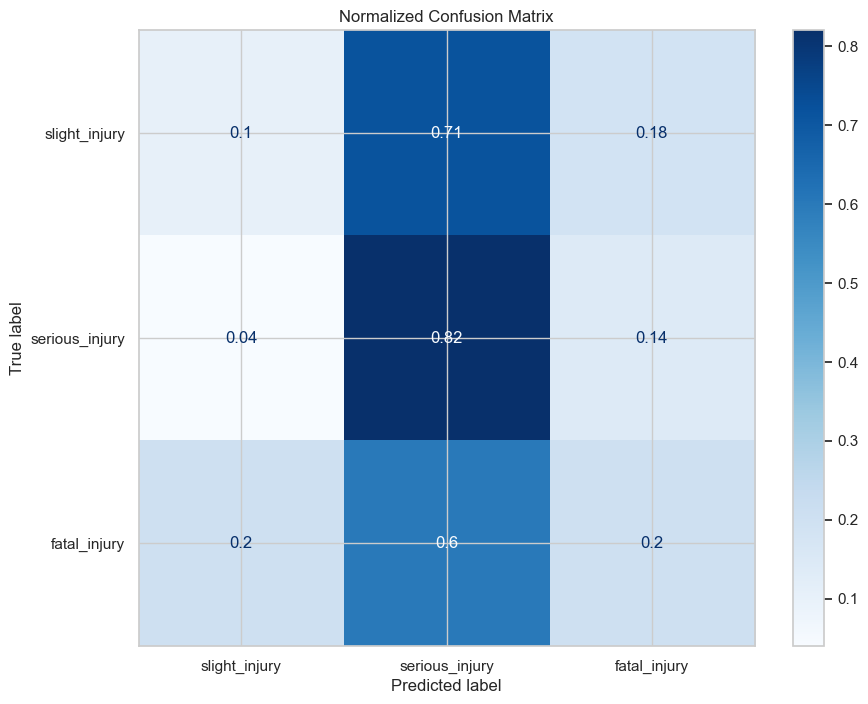


Adjusted Classification Report:
                precision    recall  f1-score   support

 slight_injury       0.90      0.24      0.38       315
serious_injury       0.19      0.44      0.27        50
  fatal_injury       0.02      0.60      0.03         5

      accuracy                           0.27       370
     macro avg       0.37      0.43      0.23       370
  weighted avg       0.80      0.27      0.36       370



In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (classification_report, confusion_matrix, 
                             balanced_accuracy_score, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_RTA_dataset.csv')

age_mapping = {
    'under18': 0,
    '18-30': 1,
    '31-50': 2,
    'over51': 3
}
df['Driver_age_code'] = df['Age_band_of_driver'].map(age_mapping)
df['Driver_age_code'] = df['Driver_age_code'].fillna(-1)  # Unknown age group

severity_mapping = {'slight_injury': 0, 'serious_injury': 1, 'fatal_injury': 2}
df['Accident_severity'] = df['Accident_severity'].map(severity_mapping)

X = df.drop(['Accident_severity', 'Time'], axis=1) 
y = df['Accident_severity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=777
)

numeric_features = ['Driver_age_code', 'Number_of_vehicles_involved', 'Number_of_casualties']
numeric_transformer = StandardScaler()

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

class_counts = y_train.value_counts()
class_weights = {i: sum(class_counts)/class_counts[i] for i in class_counts.index}

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy={2: 500, 1: 1000}, random_state=777)),  # Boost minority classes
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        class_weight=class_weights,
        max_depth=8,
        min_samples_split=10,
        random_state=777
    ))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=severity_mapping.keys()))

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=severity_mapping.keys(),
    cmap='Blues',
    ax=ax,
    normalize='true'
)
plt.title("Normalized Confusion Matrix")
plt.show()

feature_names = (pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features))
feature_names = np.concatenate([numeric_features, feature_names])

importances = pipeline.named_steps['classifier'].feature_importances_


adjusted_preds = np.argmax(y_proba * np.array([2.0, 1.5, 3.0]), axis=1) 

print("\nAdjusted Classification Report:")
print(classification_report(y_test, adjusted_preds, target_names=severity_mapping.keys()))

After the threshold adjustment, I have the following imrovements:

Fatal Injury Recall	rises from 20% to 60% which means it detects more fatalities.

Serious Injury F1 rises from 26% to 27% while weighted accuracy	rises from 20% to 27%.

*Conclusion*

In this report, I went through rather deep data exploration and feature engineering and I discovered valuable insights into accident patterns. For instance, peak accident times were identified between 4 PM and 7 PM, correlating with increased traffic from commuting. The demographic analysis showed us that younger male drivers, particularly those with junior high education, were most frequently involved in accidents. Also, it is worth to mention that the study presented specific causes of accidents such as careless driving and insufficient distance between vehicles which helps us to know areas for targeted interventions.

Our analysis also included hypothesis testing, which showed no significant correlation between gender and accident severity but it showed that vehicle type significantly affects casualty rates. The application of machine learning techniques, specially Random Forest showed the importance of driver demographics in predicting accident outcomes. To put it all in a nutshell, the findings from Addis Ababa give us valuable lessons that can inform traffic safety strategies in other urban areas like cities like Denver, Colorado.